What are DTMF signals? Whenever making a phone call, we utilize these dual-tone multi-frequency signals in order to transmit the digits pressed on the telephone keypad. Each digit corresponds to a unique pair of two associated frequencies which are then combined to form a sinusoidal waveform.

What is our goal? Our goal is to compare two potential decoding methods that detect the digit based on a frequency waveform. The first is the traditional method which utilizes fourier transfers, called Welch’s method. The second will be a deep learning model that utilizes neural networks to estimate the digit.

Before that, however, we must write code that generates these signals. Furthermore, in order to evaluate how accurate these two methods are, we will add random noise to the generated signals.


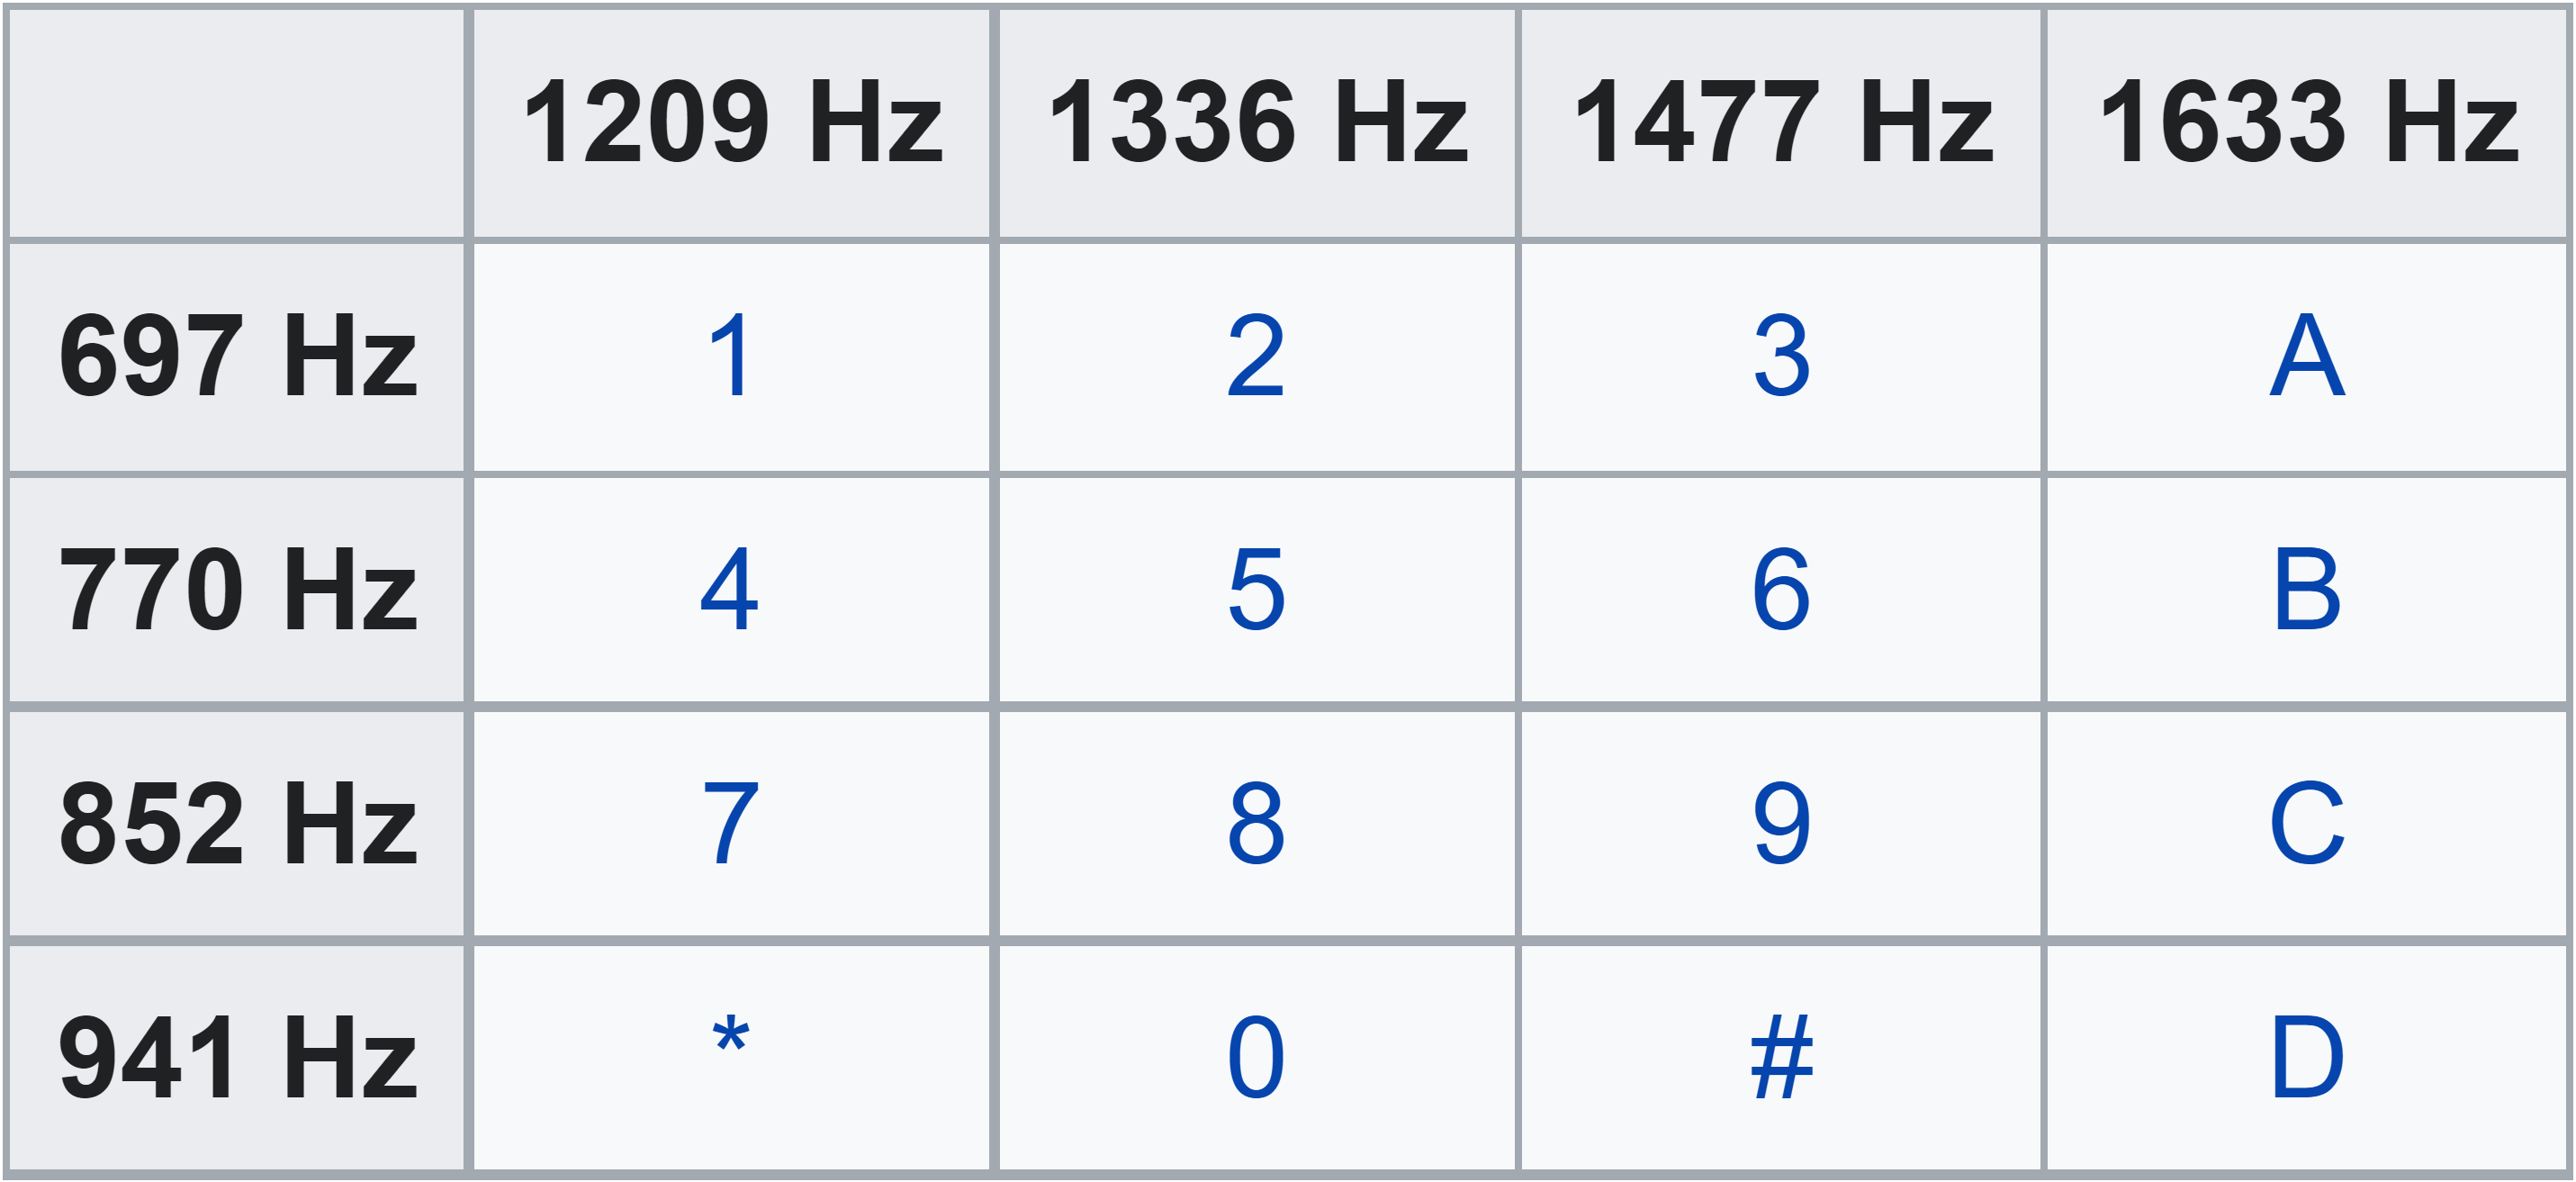

In order to synthesize the signal, we take the sum of two sinusoids with the two frequencies.

To begin with, we import all necessary packages.

In [ ]:
import numpy
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io.wavfile import write
import os
import tensorflow as tf
import keras

The first function we need is one that can generate waveforms given a phonenumber. The function will return a numpy array containing the values for the waveform. We include a parameter for mean and standard deviation which we can use to add noise to the data for testing.

In [ ]:
def waveform(phone_num, duration=100, gap=50, sampling_rate=8000, amplitude=1, graphic=False, mean=0,
             standard_deviation=0):
    '''Returns numpy array for the values of the corresponding waveform.
    There's also a 'graphic' option to include a graph.'''
    
    # Dictionary for converting digits to their frequency pairs.
    dtmf_table = {
        "1": [1209, 697],
        "2": [1336, 697],
        "3": [1477, 697],
        "A": [1633, 697],
        "4": [1209, 770],
        "5": [1336, 770],
        "6": [1477, 770],
        "B": [1633, 770],
        "7": [1209, 852],
        "8": [1336, 852],
        "9": [1477, 852],
        "C": [1633, 852],
        "*": [1209, 941],
        "0": [1336, 941],
        "#": [1477, 941],
        "D": [1633, 941],
    }

    # Check to make sure the input phonenumber contains usable digits
    phone_num = phone_num.upper()
    for digit in phone_num:
        if digit not in dtmf_table:
            raise ValueError('The only allowed digits are 0-9, A-D, #, and *')

    # Determine the amount of samples we'll need for the gap between digits.
    gap_amount_of_samples = gap * sampling_rate // 1000
    gap_values = np.zeros(gap_amount_of_samples)

    # Determine the amount of samples we'll need for each digit.
    amount_of_samples = (duration/1000)*sampling_rate
    samples = np.arange(0, duration/1000, (duration/1000)/amount_of_samples)

    # Loop through each digit and append the waveform values.
    first = True
    ans = np.array([])
    for digit in phone_num:
        if not first:
            ans = np.append(ans, gap_values)
        else:
            first = False
        values = (amplitude/2) * (
                np.sin(samples * 2 * np.pi * dtmf_table[digit][0]) +
                np.sin(samples * 2 * np.pi * dtmf_table[digit][1])
        )
        ans = np.append(ans, values)
   
    # Add random noise
    ans = ans + np.random.normal(mean, standard_deviation, len(ans))

    # Plotting
    if graphic:
        plt.title("Line graph")
        plt.xlabel("X axis")
        plt.ylabel("Y axis")
        plt.plot(np.arange(0, (len(phone_num)-1)*gap_amount_of_samples+len(phone_num)*amount_of_samples), ans, color="green")
        plt.show()

    return ans

An example waveform with no noise is shown below using the above code:

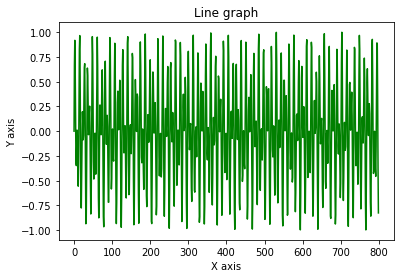

array([ 0.00000000e+00,  6.66819844e-01,  9.17725129e-01,  6.43114090e-01,
        1.02049520e-01, -3.02917340e-01, -3.47705770e-01, -1.40570342e-01,
        1.09692063e-02, -1.03544469e-01, -3.97098383e-01, -5.55397845e-01,
       -3.19725132e-01,  2.59858683e-01,  8.23415513e-01,  9.65604561e-01,
        5.55293477e-01, -1.51240510e-01, -6.99192518e-01, -7.75715044e-01,
       -4.28994322e-01,  4.80588655e-03,  1.96086035e-01,  8.76734828e-02,
       -8.74076154e-02, -4.23391420e-02,  2.82687233e-01,  6.41986532e-01,
        6.82147785e-01,  2.52960397e-01, -4.32935965e-01, -9.35091734e-01,
       -9.14579195e-01, -3.93679505e-01,  2.64242746e-01,  6.37416062e-01,
        5.60756071e-01,  2.20940274e-01, -3.54656073e-02, -9.97131207e-03,
        1.86549710e-01,  2.52714809e-01, -1.13708060e-02, -4.94765313e-01,
       -8.36333877e-01, -7.14072200e-01, -1.24932834e-01,  5.81868193e-01,
        9.54895080e-01,  7.77111188e-01,  2.19599937e-01, -3.08011610e-01,
       -4.83476422e-01, -

In [ ]:
waveform('1', graphic=True)

Additionally, we can also add noise to the waveform:

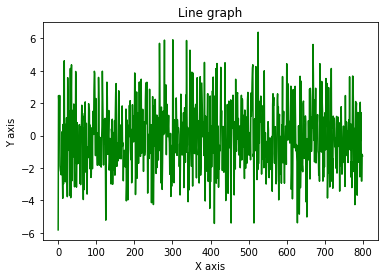

array([-5.82353122e+00,  2.46444898e+00,  1.94823155e+00,  2.69999371e-01,
        2.47129963e+00, -1.86862883e+00, -2.18795499e+00, -2.24171609e+00,
       -2.42575433e+00, -2.11243337e+00,  2.28736875e-01, -2.21007154e+00,
       -3.87668197e+00,  6.87295407e-01, -2.99004557e+00,  2.12804304e+00,
        4.61269170e+00, -1.42255145e+00, -2.50026885e+00, -2.85452507e+00,
        6.87064908e-01, -7.31966451e-01,  1.09678658e+00, -1.08086689e+00,
       -3.77504556e+00,  3.56718082e+00,  1.73323114e+00,  1.29801630e+00,
       -9.18927151e-01,  1.49424577e+00, -3.70351349e+00, -2.54202744e+00,
        4.13765484e+00, -3.83636032e+00,  2.17935179e+00,  4.36247030e+00,
       -2.79534346e+00,  7.20948937e-02,  2.20184321e-01,  1.56123517e+00,
       -1.30836104e+00,  1.94477044e+00, -1.75749695e+00, -3.16432286e+00,
        2.68867271e-01, -1.71211211e+00,  3.95195583e+00,  3.42124835e+00,
       -3.18535879e+00, -7.31958556e-01,  7.94253389e-01, -1.73424476e+00,
       -1.29657888e+00, -

In [ ]:
waveform('1', graphic=True, standard_deviation=2)

Now we must use Welch's algorithm to convert this waveform into a spectogram. This is done by using a discrete fourier transform to identify the frequencies used in the two sinusoids.

In [ ]:
def welch(waveform, fs=8000, graphic=False):
    f, Pwelch_spec = signal.welch(waveform, fs, scaling='spectrum')
    if graphic:
      plt.semilogy(f, Pwelch_spec)
      plt.xlabel('frequency [Hz]')
      plt.ylabel('PSD')
      plt.grid()
      plt.show()
    return [f, Pwelch_spec]

An example of a generated spectogram is shown below for the digit '1' when there is no noise.

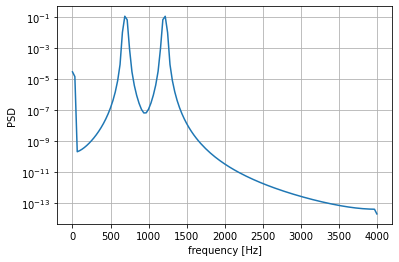

[array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
         875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
        1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
        1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
        1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
        1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
        1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
        2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
        2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
        2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
        2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,
      

In [ ]:
welch(waveform('1'), graphic=True)

The peaks are clear and easy to identify, but when noise is added they are less clear:

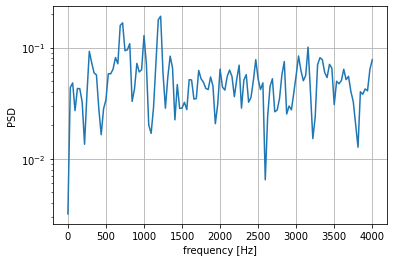

[array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
         875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
        1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
        1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
        1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
        1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
        1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
        2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
        2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
        2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
        2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,
      

In [ ]:
welch(waveform('1', standard_deviation=2), graphic=True)

The next function we need will take this spectogram as an input, identify the frequencies corresponding to each peak, and then determine the digit that matches with those frequencies. We begin by writing a function that given a list of values and a guess, will return the value in the list that is closest to the guess. This will be useful since the frequencies in the spectogram won't always be the exact value.

In [ ]:
def closest(lst, K):
    return lst[min(range(len(lst)), key=lambda i: abs(lst[i] - K))]

Next, using the 'closest' function, we write a function that identifies the frequencies corresponding to the two greatest values in the spectogram.

In [ ]:
def frequencies(f, pwelch_spec):
    # Append to two dictionaries the pairs of values from the spectograms.
    # We can use two dictionaries since we know one peak needs to be in the 
    # high range, and the other needs to be in the low range
    low_dict = {}
    high_dict = {}
    for i in range(len(f)):
      if f[i] < 1050:
        low_dict[pwelch_spec[i]] = f[i]
      elif f[i] < 1800:
        high_dict[pwelch_spec[i]] = f[i]

    low_range = list(low_dict.keys())
    high_range = list(high_dict.keys())
    
    # Calculate the frequency value corresponding to the maximum value
    low_freq = low_dict[max(low_range)]
    high_freq = high_dict[max(high_range)]

    lows = [697, 770, 852, 941]
    highs = [1209, 1336, 1477, 1633]

    # We use this table to work backwards, going from frequency to digit
    dtmf_table_freq = {
      (1209, 697): "1",
      (1336, 697): "2",
      (1477, 697): "3",
      (1633, 697): "A",
      (1209, 770): "4",
      (1336, 770): "5",
      (1477, 770): "6",
      (1633, 770): "B",
      (1209, 852): "7",
      (1336, 852): "8",
      (1477, 852): "9",
      (1633, 852): "C",
      (1209, 941): "*",
      (1336, 941): "0",
      (1477, 941): "#",
      (1633, 941): "D",
    }
    # Use the 'closest' function to identify which potential input frequency the 
    # peaks are closest too
    return dtmf_table_freq[(closest(highs, high_freq), closest(lows, low_freq))]

An example use of this function is shown below. We input the waveform for '1', and frequencies outputs the correct value.

In [ ]:
frequencies(welch(waveform('1'))[0], welch(waveform('1'))[1])

'1'

In order to evaluate the accuracy of this approach, we run through multiple standard deviations for generating noise, and we create confusion matrices to summarize our results.

In [ ]:
# We use these as the indexes for the rows and columns in our confusion matrices
indexes = {
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    '0' : 0,
    'A' : 10,
    'B' : 11,
    'C' : 12,
    'D' : 13,
    '#' : 14,
    '*' : 15,
}

# These will be used to calculate our total accuracy accross all standard 
# deviations
total = 0
amount = 0

# We set our phonenumber equal to all possible inputs
PHONE_NUMBER = "1234567890ABCD#*"

# Loop through all potential standard deviations, from 1.8, when we first get 
# errors, to 4.5, where our accuracy dips to that of random guessing.
for standard_deviation in range(180,504,54):
    amount += 1
    standard_deviation = standard_deviation/100

    # Initialize our confusion matrix
    confusionMatrix = np.zeros(256).reshape(16,16)
    names = [_ for _ in '1234567890ABCD#*']
    for digit in PHONE_NUMBER:
        
        # Run 100 tests for each digit for each standard deviation
        i = 1
        while i <= 100:
            # Calculate welch's method
            temp = welch(waveform(digit, standard_deviation=standard_deviation), 8000)

            # Calculate welch's guess for the input
            guess = frequencies(temp[0], temp[1])

            # Increment the correct part of the confusion matrix
            confusionMatrix[indexes[digit]][indexes[guess]] += 1
            i += 1

    # Add the sum to total for calculating the overall accuracy
    for digit in PHONE_NUMBER:
        total += confusionMatrix[indexes[digit]][indexes[digit]]

    # Save to csv
    df = pd.DataFrame(confusionMatrix, index=names, columns=names)
    df.to_csv('std_dev' + str(standard_deviation) + '.csv', index=True, header=True, sep=',')


print("Total accuracy:", total/(16*amount))


Total accuracy: 42.020833333333336


We add to this code so that we can also save our waveforms for training and testing data for our neural network. We use 6 standard deviations ranging from 1.8 to 4.5, and create 100 graphs for each deviation. There are a total of 9600 inputs in the training and testing set, each.

In [ ]:
# We first loop to create training data, using the same code from above.
training_data = []
PHONE_NUMBER = "#1234567890ABCD#*"

# Loop through all potential standard deviations, from 1.8, when we first get 
# errors, to 4.5, where our accuracy dips to that of random guessing.
for standard_deviation in range(180,504,54):
    standard_deviation = standard_deviation/100

    # Initialize our confusion matrix
    confusionMatrix = np.zeros(256).reshape(16,16)
    names = [_ for _ in '1234567890ABCD#*']
    for digit in PHONE_NUMBER:
        
        # Run 100 tests
        i = 1
        while i <= 100:
            # Calculate the waveform
            temp = waveform(digit, standard_deviation=standard_deviation)
            
            # Evaluate welch's method
            temp1 = welch(temp, 8000)

            # We extract the y values only, since for our neural network, the 
            # x-values are useless as they'll be the same for each input
            temp11 = temp1[1]

            # Create training data folder
            if not os.path.isdir("Training data"):
              os.mkdir("Training data")
            
            # We have to check if the digit is '*' or '#' since they could cause
            # errors when saving files. Additionally we also have to create all 
            # the folders containing our training and testing data
            if digit != '*' and digit != '#':
                if not os.path.isdir("Training data/" + str(digit)):
                    os.mkdir("Training data/" + str(digit))
                if not os.path.isdir("Training data/" + str(digit)+"/"+str(standard_deviation)):
                    os.mkdir("Training data/" + str(digit)+"/"+str(standard_deviation))
                
                # Save data as numpy array, and append to training data
                numpy.savetxt("Training data/"+str(digit)+"/"+str(standard_deviation)+"/"+str(i)+".csv", temp11, delimiter=',')
                training_data.append((temp11, digit))
            elif digit == '*':
                if not os.path.isdir("Training data/" + str('pound')):
                    os.mkdir("Training data/" + str('pound'))
                if not os.path.isdir("Training data/" + str('pound')+"/"+str(standard_deviation)):
                    os.mkdir("Training data/" + str('pound')+"/"+str(standard_deviation))
               
                # Save data as numpy array, and append to training data
                numpy.savetxt("Training data/"+str('pound')+"/"+str(standard_deviation)+"/"+str(i)+".csv", temp11, delimiter=',')
                training_data.append((temp11, digit))
            elif digit == '#':
                if not os.path.isdir("Training data/" + str('hash')):
                    os.mkdir("Training data/" + str('hash'))
                if not os.path.isdir("Training data/" + str('hash') + "/" + str(standard_deviation)):
                    os.mkdir("Training data/" + str('hash') + "/" + str(standard_deviation))
              
               # Save data as numpy array, and append to training data
                numpy.savetxt("Training data/"+str('hash')+"/"+str(standard_deviation)+"/"+str(i)+".csv", temp11, delimiter=',')
                training_data.append((temp11, digit))
           
            # Add to the correct part of the confusion matrix
            guess = frequencies(temp1[0], temp1[1])
            confusionMatrix[indexes[digit]][indexes[guess]] += 1
            i += 1
    
    # Saving the confusion matrix as a csv
    df = pd.DataFrame(confusionMatrix, index=names, columns=names)
    df.to_csv('std_dev' + str(standard_deviation) + '.csv', index=True, header=True, sep=',')
    

# The steps for creating the testing_data are the same as for creating the
# training data
testing_data = []
PHONE_NUMBER = "#1234567890ABCD#*"
for standard_deviation in range(180,504,54):
    standard_deviation = standard_deviation/100
    confusionMatrix = np.zeros(256).reshape(16,16)
    names = [_ for _ in '1234567890ABCD#*']
    for digit in PHONE_NUMBER:
        i = 1
        while i <= 100:
            temp = waveform(digit, standard_deviation=standard_deviation)
            temp1 = welch(temp, 8000)
            temp11 = temp1[1]
            if not os.path.isdir("Testing data"):
              os.mkdir("Testing data")
            if digit != '*' and digit != '#':
                if not os.path.isdir("Testing data/" + str(digit)):
                    os.mkdir("Testing data/" + str(digit))
                if not os.path.isdir("Testing data/" + str(digit)+"/"+str(standard_deviation)):
                    os.mkdir("Testing data/" + str(digit)+"/"+str(standard_deviation))
                numpy.savetxt("Testing data/"+str(digit)+"/"+str(standard_deviation)+"/"+str(i)+".csv", temp11, delimiter=',')
                testing_data.append((temp11, digit))
            elif digit == '*':
                if not os.path.isdir("Testing data/" + str('pound')):
                    os.mkdir("Testing data/" + str('pound'))
                if not os.path.isdir("Testing data/" + str('pound')+"/"+str(standard_deviation)):
                    os.mkdir("Testing data/" + str('pound')+"/"+str(standard_deviation))
                numpy.savetxt("Testing data/"+str('pound')+"/"+str(standard_deviation)+"/"+str(i)+".csv", temp11, delimiter=',')
                testing_data.append((temp11, digit))
            elif digit == '#':
                if not os.path.isdir("Testing data/" + str('hash')):
                    os.mkdir("Testing data/" + str('hash'))
                if not os.path.isdir("Testing data/" + str('hash') + "/" + str(standard_deviation)):
                    os.mkdir("Testing data/" + str('hash') + "/" + str(standard_deviation))
                numpy.savetxt("Testing data/"+str('hash')+"/"+str(standard_deviation)+"/"+str(i)+".csv", temp11, delimiter=',')
                testing_data.append((temp11, digit))
            guess = frequencies(temp1[0], temp1[1])
            confusionMatrix[indexes[digit]][indexes[guess]] += 1
            i += 1
    df = pd.DataFrame(confusionMatrix, index=names, columns=names)
    df.to_csv('testing_std_dev' + str(standard_deviation) + '.csv', index=True, header=True, sep=',')

This next code builds and evaluates a neural network. It starts off with separating the training and testing data into labels and input arrays. After this, we build our neural network with 6 layers, using different hyperparameters and layer types. The model is trained with the training data and then used to evaluate the accuracy of the deep learning model, using the testing data.

In [ ]:
total = 0
for x in range(1):
  tf.random.set_seed(x)
  

  # Create training and testing arrays and labels from the previously made data
  training_arrays = []
  training_labels = []
  for pair in training_data:
      training_arrays.append(pair[0])
      training_labels.append(int(indexes[pair[1]]))

  testing_arrays = []
  testing_labels = []
  for pair in testing_data:
      testing_arrays.append(pair[0])
      testing_labels.append(int(indexes[pair[1]]))


  training_arrays = np.asarray(training_arrays)
  training_labels = np.asarray(training_labels)
  testing_arrays = np.asarray(testing_arrays)
  testing_labels = np.asarray(testing_labels)

  # Create the layers to the model
  model = tf.keras.models.Sequential([                              
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=.097)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.18, input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
  ])

  # Fit the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.fit(training_arrays, training_labels, epochs = 5)
  count = 0

  test_loss, test_accuracy = model.evaluate(testing_arrays, testing_labels)
  total += test_accuracy*100
  print ('Test loss: {}, Test accuracy: {}'.format(test_loss, test_accuracy*100))


Epoch 1/5
319/319 [==============================] - 2s 3ms/step - loss: 2.6195 - accuracy: 0.1652
Epoch 2/5
319/319 [==============================] - 1s 2ms/step - loss: 2.0409 - accuracy: 0.4144
Epoch 3/5
319/319 [==============================] - 1s 2ms/step - loss: 1.6316 - accuracy: 0.5171
Epoch 4/5
319/319 [==============================] - 1s 2ms/step - loss: 1.4497 - accuracy: 0.5530
Epoch 5/5
319/319 [==============================] - 0s 1ms/step - loss: 1.3648 - accuracy: 0.5680
Test loss: 1.3647736310958862, Test accuracy: 56.80392384529114


Our total accuracy is 56.80%, which is a significant improvement from welch's method.